In [2]:
import astropy.coordinates as coord
import astropy.units as u
from astropy.table import Table, join, vstack
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astropy.io import ascii

from scipy.interpolate import interp1d
from scipy.stats import binned_statistic

import gala.coordinates as gc
import gala.dynamics as gd
from gala.units import galactic
from pyia import GaiaData

In [3]:
g = GaiaData('/Users/adrian/data/APOGEE_DR15beta/allStar-t9-l31c-58158-with-gaiadr2.fits')
len(g)

397129

In [4]:
galcen = coord.Galactocentric(galcen_distance=8.1*u.kpc, z_sun=0*u.pc)

In [41]:
vasi_tbl = Table.read('/Users/adrian/data/Misc/Vasiliev-globclust.txt', 
                      format='ascii.fixed_width')

pal5_glob = vasi_tbl[vasi_tbl['Name'] == 'Pal 5']

cl_c = coord.SkyCoord(ra=pal5_glob['RA']*u.deg,
                      dec=pal5_glob['DEC']*u.deg,
                      distance=(pal5_glob['D']-2.6)*u.kpc,
                      pm_ra_cosdec=pal5_glob['PMRA']*u.mas/u.yr,
                      pm_dec=pal5_glob['PMDEC']*u.mas/u.yr,
                      radial_velocity=(pal5_glob['Vlos'])*u.km/u.s)
cl_streamc = cl_c.transform_to(gc.Pal5)

### Polygonal selections in each observable:

In [10]:
# Over-densities along stream from Küpper work
l_cos_b = np.array([14.66, 13.71, 12.96, 12.28, 11.77, 11.28, 9.65, 8.85,
                    8.39, 7.26, 6.02, 5.43, 4.74, 4.14, 3.70, 3.04, 2.50,
                    1.82, 1.27, -0.06, -0.95, -1.37, -1.73, -2.05]) * u.degree
b = np.array([39.19, 39.64, 40.06, 40.48, 40.84, 41.25, 42.33, 42.68, 42.75,
              43.69, 44.37, 44.68, 44.89, 45.11, 45.15, 45.45, 45.54, 45.80,
              45.83, 45.79, 45.89, 45.82, 45.84, 46.13]) * u.degree
overdens = coord.SkyCoord(l=l_cos_b / np.cos(b), b=b, frame='galactic')
overdens_pal5 = overdens.transform_to(gc.Pal5)

In [46]:
toy_posvel = np.load('/Users/adrian/projects/pal5-bar/output/toy_model.npy')
toy_w0 = gd.PhaseSpacePosition(pos=toy_posvel[:, :3].T*u.kpc,
                               vel=toy_posvel[:, 3:].T*u.km/u.s)
toy_stream_c = toy_w0.to_coord_frame(gc.Pal5, galcen)

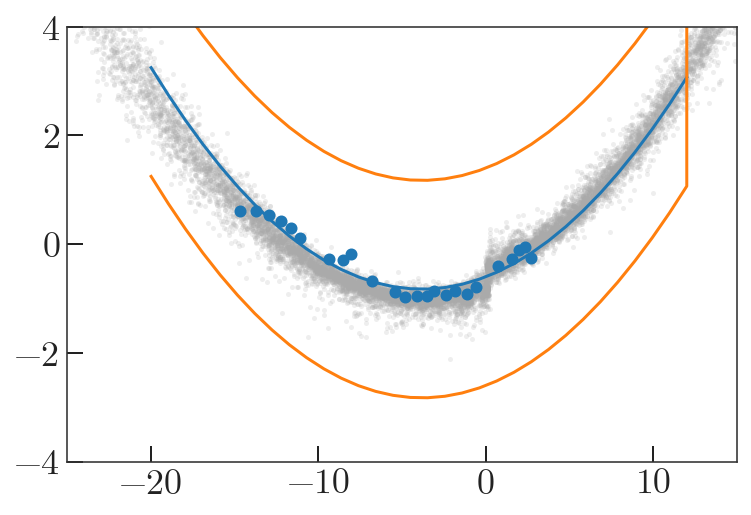

In [117]:
plt.scatter(overdens_pal5.phi1.wrap_at(180*u.deg).degree,
            overdens_pal5.phi2)

plt.plot(toy_stream_c.phi1.wrap_at(180*u.deg).degree, toy_stream_c.phi2.degree,
         marker='.', ls='none', zorder=-100, color='#aaaaaa', alpha=0.2)

phi2_poly = np.poly1d(np.polyfit(overdens_pal5.phi1.wrap_at(180*u.deg).degree,
                                 overdens_pal5.phi2, deg=2))

_grid = np.linspace(-20, 12, 32)
plt.plot(_grid, phi2_poly(_grid), marker='')
plt.xlim(-25, 15)
plt.ylim(-4, 4)

_l = np.vstack((_grid, phi2_poly(_grid) - 2)).T
_r = np.vstack((_grid, phi2_poly(_grid) + 2)).T
phi12_poly = np.vstack((_l, _r[1:][::-1]))
plt.plot(phi12_poly[:, 0], phi12_poly[:, 1], marker='')

Text(0,0.5,'RV [km/s]')

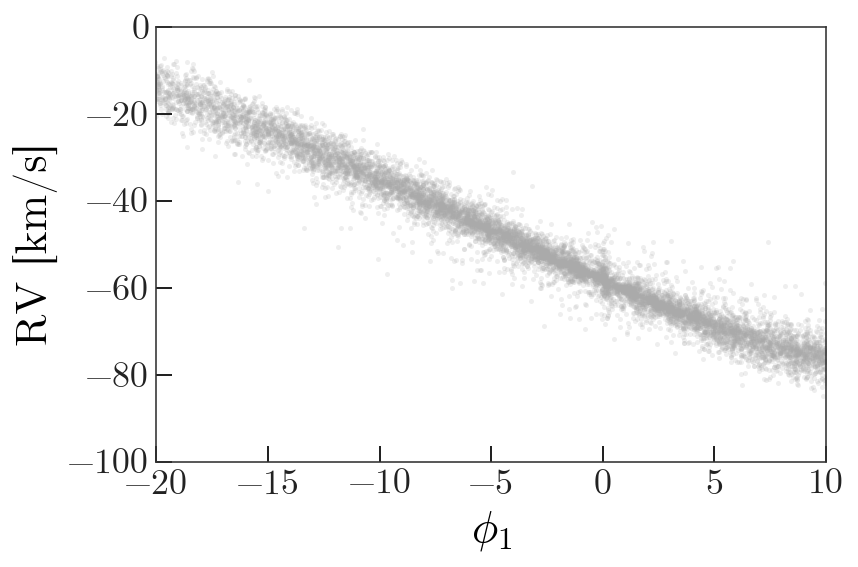

In [118]:
plt.plot(toy_stream_c.phi1.wrap_at(180*u.deg).degree, 
         toy_stream_c.radial_velocity.value,
         marker='.', ls='none', zorder=-100, color='#aaaaaa', alpha=0.2)
plt.xlim(-20, 10)
plt.ylim(-100, 0)
plt.xlabel(r'$\phi_1$')
plt.ylabel('RV [km/s]')

In [119]:
model_phi1 = toy_stream_c.phi1.wrap_at(180*u.deg)
model_mask = (model_phi1 > -25*u.deg) & (model_phi1 < 10*u.deg)

model_phi1 = model_phi1[model_mask]
model_streamc = toy_stream_c[model_mask]

Text(0,0.5,'$\\mu_2$')

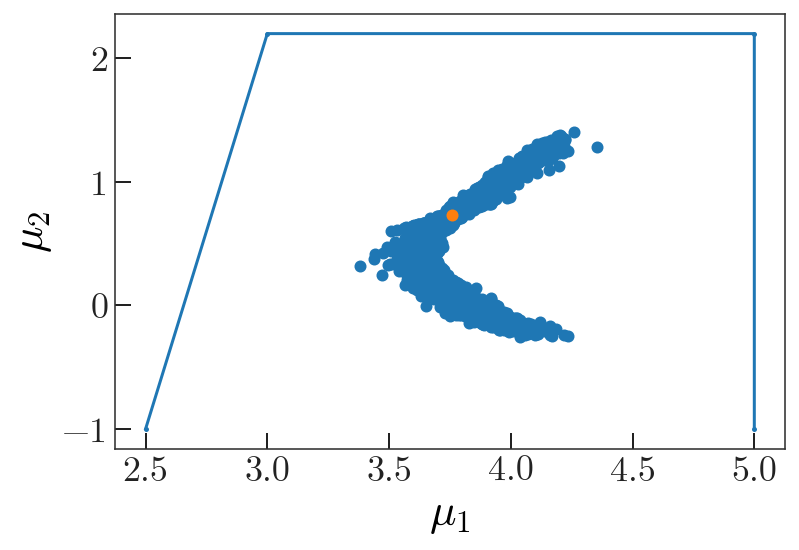

In [120]:
plt.scatter(model_streamc.pm_phi1_cosphi2, 
            model_streamc.pm_phi2)

pm_poly = np.array([[2.5, -1],
                    [3., 2.2],
                    [5, 2.2],
                    [5, -1]])

plt.plot(pm_poly[:, 0], pm_poly[:, 1])
plt.scatter(cl_streamc.pm_phi1_cosphi2, cl_streamc.pm_phi2)
plt.xlabel(r'$\mu_1$')
plt.ylabel(r'$\mu_2$')

---

# APOGEE

In [121]:
c = g.get_skycoord(distance=25*u.kpc, 
                   radial_velocity=np.array(g.VHELIO_AVG)*u.km/u.s)
stream_c = c.transform_to(gc.Pal5)

apogee_phi1 = stream_c.phi1.wrap_at(180*u.deg)
apogee_phi2 = stream_c.phi2

apogee_mask = ((apogee_phi1 > -20*u.deg) & (apogee_phi1 < 12*u.deg) &
               (apogee_phi2 > -5*u.deg) & (apogee_phi2 < 5*u.deg))

stream_c = stream_c[apogee_mask]

apogee_phi1 = stream_c.phi1.wrap_at(180*u.deg)
apogee_phi2 = stream_c.phi2

apogee_pm1 = stream_c.pm_phi1_cosphi2.to(u.mas/u.yr)
apogee_pm2 = stream_c.pm_phi2.to(u.mas/u.yr)

In [122]:
phi12_mask = mpl.patches.Path(phi12_poly).contains_points(np.vstack((apogee_phi1, apogee_phi2)).T)
pm_mask = mpl.patches.Path(pm_poly).contains_points(np.vstack((apogee_pm1, apogee_pm2)).T)
# rv_mask = mpl.patches.Path(rv_poly).contains_points(np.vstack((apogee_phi1, g.VHELIO_AVG[apogee_mask])).T)
rv_mask = np.ones(len(pm_mask), dtype=bool)
kin_mask = phi12_mask & pm_mask & rv_mask

In [123]:
phi12_mask.sum(), pm_mask.sum(), rv_mask.sum(), kin_mask.sum()

(2235, 91, 2346, 89)

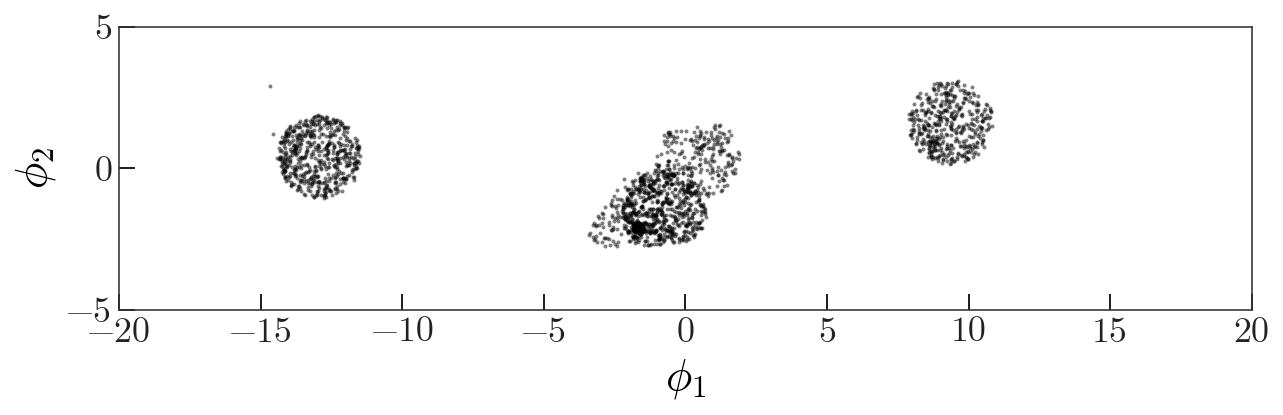

In [124]:
fig, ax = plt.subplots(1, 1, figsize=(15, 3))

ax.plot(apogee_phi1[phi12_mask], apogee_phi2[phi12_mask], 
        marker='o', color='k', ms=2,
        ls='none', alpha=0.5)

ax.set_xlim(-20, 20)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')

fig.tight_layout()

In [125]:
feh_mask = (g.M_H[apogee_mask] < -0.8) & (g.M_H[apogee_mask] > -2.5)
gd1_full_mask = kin_mask & feh_mask
gd1_full_mask.sum()

40

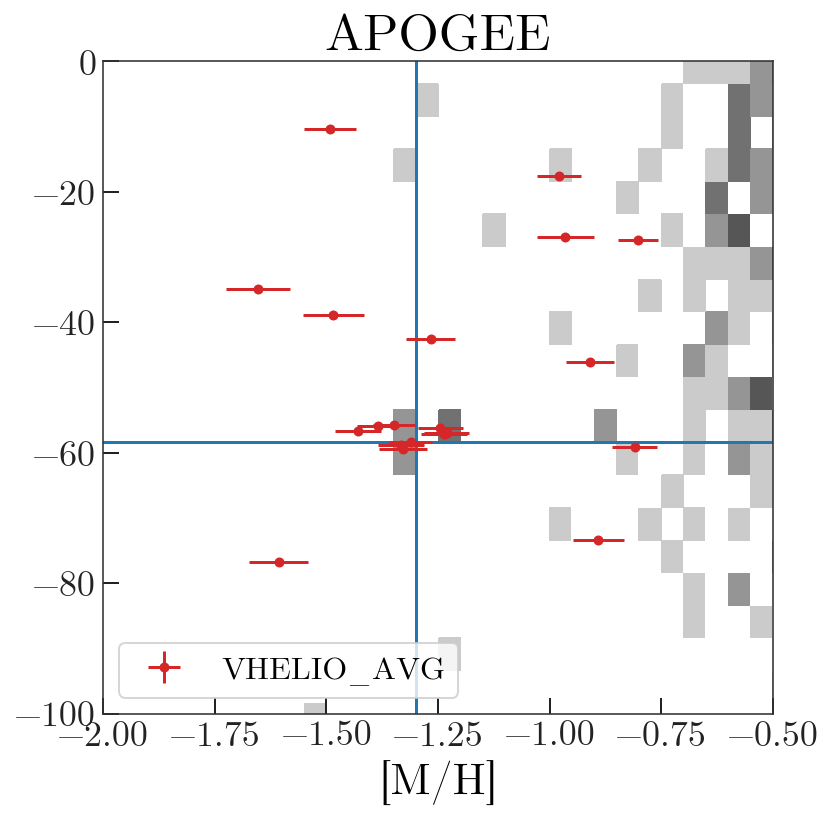

In [126]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.errorbar(g.M_H[apogee_mask][gd1_full_mask], 
            g.VHELIO_AVG[apogee_mask][gd1_full_mask],
            xerr=g.M_H_ERR[apogee_mask][gd1_full_mask], 
            yerr=g.VERR[apogee_mask][gd1_full_mask], 
            marker='o', ls='none', color='tab:red', 
            zorder=100)

H, xe, ye = np.histogram2d(g.M_H[apogee_mask][phi12_mask],
                           g.VHELIO_AVG[apogee_mask][phi12_mask],
                           bins=(np.arange(-3, 0+1e-3, 0.05),
                                 np.arange(pal5_glob['Vlos']-100, 
                                           pal5_glob['Vlos']+100+1e-3, 
                                           5)))
ax.pcolormesh(xe, ye, H.T, cmap='Greys', zorder=-100, 
              norm=mpl.colors.LogNorm())

ax.axhline(pal5_glob['Vlos'], zorder=-10, color='tab:blue', marker='')
ax.axvline(-1.3, zorder=-10, color='tab:blue', marker='')

ax.set_xlim(-2, -0.5)
ax.set_ylim(-100, 0)

ax.legend(loc='lower left', fontsize=16)

ax.set_xlabel('[M/H]')
# ax.set_ylabel(r'[$\alpha$/M]')

ax.set_title('APOGEE')
fig.set_facecolor('w')

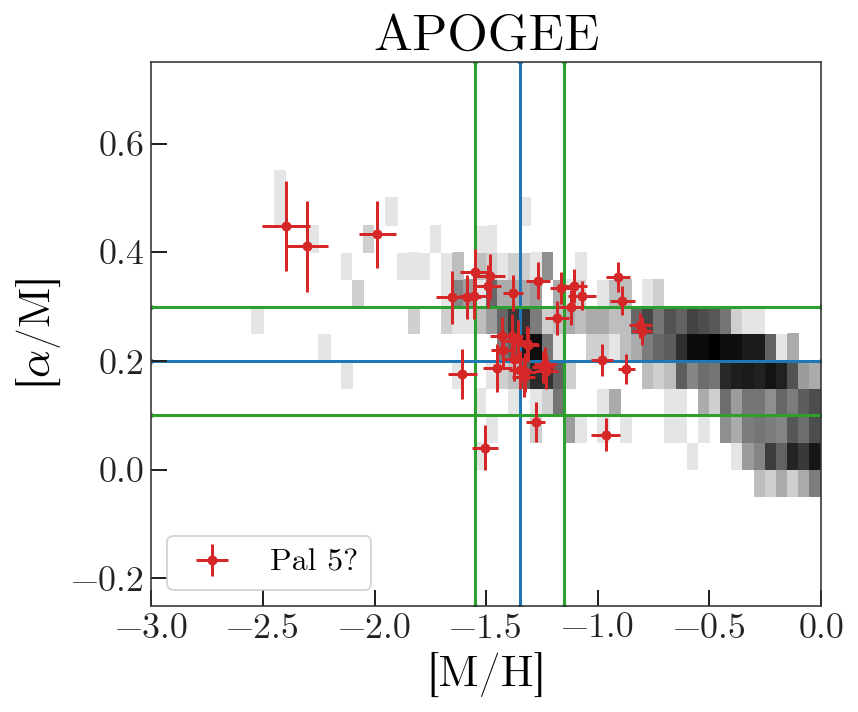

In [127]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

ax.errorbar(g.M_H[apogee_mask][gd1_full_mask], 
            g.ALPHA_M[apogee_mask][gd1_full_mask],
            xerr=g.M_H_ERR[apogee_mask][gd1_full_mask], 
            yerr=g.ALPHA_M_ERR[apogee_mask][gd1_full_mask], 
            marker='o', ls='none', color='tab:red', 
            label='Pal 5?', zorder=100)

H, xe, ye = np.histogram2d(g.M_H[apogee_mask][phi12_mask],
                           g.ALPHA_M[apogee_mask][phi12_mask],
                           bins=(np.arange(-3, 0+1e-3, 0.05),
                                 np.arange(-1, 1+1e-3, 0.05)))
ax.pcolormesh(xe, ye, H.T, cmap='Greys', zorder=-100, 
              norm=mpl.colors.LogNorm())

ax.set_xlim(-3, 0)
ax.set_ylim(-0.25, 0.75)

ax.legend(loc='lower left', fontsize=16)

ax.set_xlabel('[M/H]')
ax.set_ylabel(r'[$\alpha$/M]')

M_H_mean = -1.35
A_M_mean = 0.2
ax.axvline(M_H_mean, zorder=-100, color='tab:blue')
ax.axvline(M_H_mean+0.2, zorder=-100, color='tab:green')
ax.axvline(M_H_mean-0.2, zorder=-100, color='tab:green')

ax.axhline(A_M_mean, zorder=-100, color='tab:blue')
ax.axhline(A_M_mean+0.1, zorder=-100, color='tab:green')
ax.axhline(A_M_mean-0.1, zorder=-100, color='tab:green')

MH_ALPHAM_mask = np.sqrt(((g.M_H - M_H_mean)/(0.2))**2 + ((g.ALPHA_M - A_M_mean)/(0.1))**2) < 1.

ax.set_title('APOGEE')
fig.set_facecolor('w')

(-1, 2)

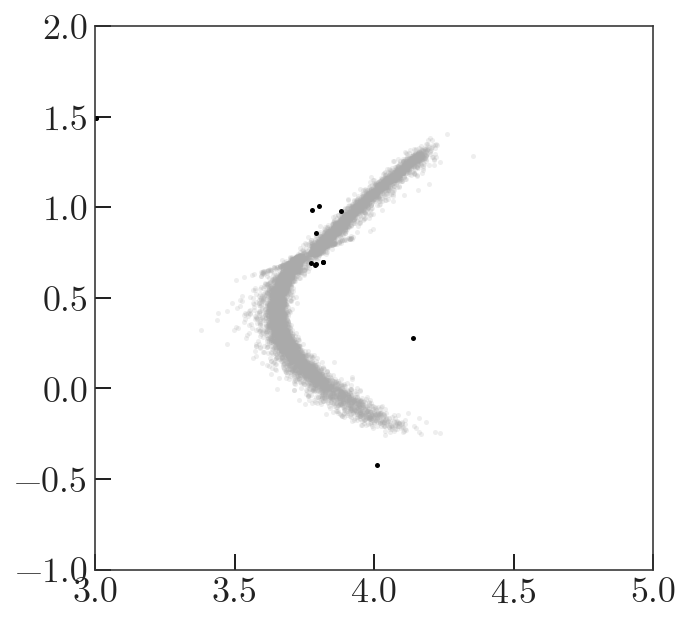

In [128]:
mask = phi12_mask & MH_ALPHAM_mask[apogee_mask]

# H, xe, ye = np.histogram2d(stream_c.pm_phi1_cosphi2[mask], 
#                            stream_c.pm_phi2[mask],
#                            bins=(np.arange(0, 10+1e-3, 0.5),
#                                  np.arange(-5, 5+1e-3, 0.5)))

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.pcolormesh(xe, ye, H.T)
ax.plot(stream_c.pm_phi1_cosphi2[mask], 
        stream_c.pm_phi2[mask], 
        marker='.', ls='none', alpha=1, color='k')

ax.plot(model_streamc.pm_phi1_cosphi2, 
        model_streamc.pm_phi2, 
        marker='.', ls='none', alpha=0.2, 
        color='#aaaaaa', zorder=-100)

ax.set_xlim(3, 5)
ax.set_ylim(-1, 2)